In [16]:
# Built-in modules
import sys, os, argparse
from collections import OrderedDict, defaultdict
# Public modules
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import progressbar

from torchvision.datasets import ImageFolder
from torchvision.transforms import CenterCrop, ColorJitter, Compose, \
        Normalize, Resize, RandomCrop, RandomHorizontalFlip, \
        RandomRotation, ToTensor
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
from utils import SimpleAUC
from torch.autograd import Variable
import cv2

os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Setting parameters

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
init_lr = 1e-4
batch_size = 32
num_epochs = 200
steps_per_epoch = 2000
weight_decay = 1e-5

cnn_name = "model_augmentation"

tag = "model_augmentation"

In [3]:
checkpoint_dir = './train_logs/' + cnn_name

In [4]:
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, '{}.pt'.format(tag))
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    print('Load model trained for {} epochs.'.format(checkpoint['epoch']))
else:
    checkpoint = None

Load model trained for 192 epochs.


# Build dataset

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class RetinaDataset(Dataset):
    """ Custom dataset for Retina image dataset """
    def __init__(self,
                 csv_df,
                 img_dir,
                 transform=None,
                 standardize=False):
        """
        Args:
            csv_path (str): A path to the csv file.
            img_dir (str): A path to the fundus image dir.
            transform (callable, optional): Tranform function
                to be applied fundus images.
            standardize (bool): Whether to apply standardize to numeric data.
        """
        super().__init__()
        self.df = csv_df
        self.img_dir = img_dir
        self.transform = transform
        self.standardize = standardize

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """ read left and right retina image """
        path = os.path.join(self.img_dir, self.df['image'].values[i]+".jpeg")

        sample = {}
        sample['fundus'] = Image.open(path)
        sample["level"] = 1 if self.df["level"].values[i] > 0 else 0

        if self.transform is not None:
            sample['fundus'] = self.transform(sample['fundus'])
        return sample
    
def build_dataset():
    """ Build dataset """
    transform_train = Compose([Resize([256, 256]),
                               RandomCrop([224, 224]),
                               ColorJitter(brightness=0.2,
                                           saturation=1),
                               RandomHorizontalFlip(),
                               RandomRotation(degrees=30),
                               ToTensor(),
                               Normalize(IMAGENET_MEAN, IMAGENET_STD)])
    transform_eval = Compose([Resize([256, 256]),
                              CenterCrop([224, 224]),
                              ToTensor(),
                              Normalize(IMAGENET_MEAN, IMAGENET_STD)])

    
    
    df = pd.read_csv("../kaggle_data/trainLabels.csv")
    n_samples = len(df)
    train_df = df[0:int(n_samples*0.8)]
    val_df = df[int(n_samples*0.8):]
    
    IMG_DIR = "../kaggle_data/train_resize"
    
    dataset = {'train': RetinaDataset(csv_df=train_df,
                                   img_dir=IMG_DIR,
                                   transform=transform_train),
               'valid' : RetinaDataset(csv_df=val_df,
                                   img_dir=IMG_DIR,
                                  transform=transform_eval)}

        

    return dataset

In [6]:
dataset = build_dataset()
loader = {}
for key in ['train', 'valid']:
    shuffle = (key != 'valid')
    loader[key] = DataLoader(dataset[key], batch_size=batch_size, shuffle=shuffle,
                             pin_memory=True, num_workers=4)

# Define Model

In [7]:
_model_dict = {
            'resnet18' : torchvision.models.resnet18,
            'resnet34' : torchvision.models.resnet34,
            'resnet50' : torchvision.models.resnet50,
            'resnet101' : torchvision.models.resnet101,
        }

class Classifier(nn.Module):
    """ Pre-trained model to which new layers are attached. """
    def __init__(self,
                 cnn_name,
                 num_classes,
                 pretrained=False):
        """ Initialize module
        Args:
            cnn_name (str): The name of a pretrained CNN model.
            num_classes (int): The number of output classes.
        """
        super().__init__()
        if cnn_name not in _model_dict.keys():
            raise NotImplementedError('{} is not supported.'.format(cnn_name))

        self.num_classes = num_classes
        self.model = _model_dict[cnn_name](pretrained=pretrained)
        self.model.fc = nn.Linear(512, num_classes)
        
        conv = nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, fundus):
        """ forward pass """
        h = self.model(fundus)
        return h
    


In [8]:

cls = Classifier('resnet18', num_classes=2,
        pretrained=False)
cls.load_state_dict(checkpoint['cls_state_dict'])
cls.to(device)

Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [9]:
cls.eval()

Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [10]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

cls.model._modules.get("layer4").register_forward_hook(hook_feature)

In [11]:
params = list(cls.parameters())
# get only weight from last layer(linear)
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx=[1]):
    size_upsample = (128, 128)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape( (nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam/np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

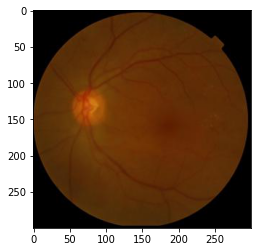

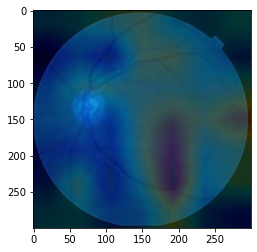

In [23]:

filename = "44200_left.jpeg"

preprocess = Compose([Resize([256, 256]),
              CenterCrop([224, 224]),
              ToTensor(),
              Normalize(IMAGENET_MEAN, IMAGENET_STD)])

img_pil = Image.open("../kaggle_data/train_resize/"+filename)

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0)).to(device)


logit = cls(img_variable)


# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax)

img = cv2.imread("../kaggle_data/train_resize/"+filename)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.2 + img * 0.8

plt.figure()
plt.imshow(Image.open("../kaggle_data/train_resize/"+filename))
plt.figure()
plt.imshow(result.astype(int))